In [55]:
import numpy as np 
np.set_printoptions(precision=4)
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm
from scipy.special import j1
import matplotlib.pyplot as plt
import matplotlib as mpl
import infomeasure as im
from sklearn.cluster import KMeans
from scipy.spatial import cKDTree

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [56]:
def sample_from_pdf_2d(pdf, x_bounds, y_bounds, n_samples):
    samples = []
    xmin, xmax = x_bounds
    ymin, ymax = y_bounds
    
    # Find max of pdf in bounding box (or approximate)
    xs = np.linspace(xmin, xmax, 200)
    ys = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(xs, ys)
    Z = np.array([[pdf((x, y)) for x in xs] for y in ys])
    M = Z.max()  # Upper bound
    
    while len(samples) < n_samples:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)
        u = np.random.uniform(0, M)
        if u < pdf(np.array((x, y))):   # accept
            samples.append([x, y])
    return np.array(samples)

In [57]:
# Define the target distribution
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)
        
# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension
# Discretize the search space into 100-by-100 mesh grids
num_grid = 256
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T

dx = 1.0 / (num_grid - 1)
dy = 1.0 / (num_grid - 1)
pdf_vals = pdf(grids)


In [58]:
def build_partition(mu_samples, N, method="kmeans"):
    """
    Returns centroids, labels for mu_samples, target_probs
    method: "kmeans", "grid", "random_samples", "recursive"
    """
    if method == "kmeans":
        kmeans = KMeans(n_clusters=N, random_state=42)
        kmeans.fit(mu_samples)
        centroids = kmeans.cluster_centers_
        labels = kmeans.predict(mu_samples)
        tree = cKDTree(centroids)
        labels = tree.query(mu_samples)[1]

    elif method == "grid":
        # 2D uniform grid
        nx = int(np.sqrt(N))
        ny = int(np.sqrt(N))
        xs = np.linspace(0, 1, nx)
        ys = np.linspace(0, 1, ny)
        X, Y = np.meshgrid(xs, ys, indexing="ij")
        centroids = np.stack([X.ravel(), Y.ravel()], axis=-1)

        # Assign each sample to nearest centroid
        tree = cKDTree(centroids)
        labels = tree.query(mu_samples)[1]

    elif method == "random_samples":
        # Randomly select N points as centroids
        idx = np.random.choice(len(mu_samples), N, replace=False)
        centroids = mu_samples[idx]
        tree = cKDTree(centroids)
        labels = tree.query(mu_samples)[1]

    elif method == "recursive":
        # Recursive quadtree-like splitting
        # For simplicity, do 2^k x 2^k split for some k
        nx = int(np.sqrt(N))
        ny = int(np.sqrt(N))
        xs = np.linspace(0, 1, nx+1)
        ys = np.linspace(0, 1, ny+1)
        centroids = []
        labels = np.zeros(len(mu_samples), dtype=int)
        cell_idx = 0
        for i in range(nx):
            for j in range(ny):
                x0, x1 = xs[i], xs[i+1]
                y0, y1 = ys[j], ys[j+1]
                in_cell = np.where(
                    (mu_samples[:,0] >= x0) & (mu_samples[:,0] < x1) &
                    (mu_samples[:,1] >= y0) & (mu_samples[:,1] < y1)
                )[0]
                labels[in_cell] = cell_idx
                centroids.append([0.5*(x0+x1), 0.5*(y0+y1)])
                cell_idx += 1
        centroids = np.array(centroids)
    
    else:
        raise ValueError(f"Unknown method {method}")

    # Target probabilities
    target_probs = np.zeros(len(centroids))
    for i in range(len(centroids)):
        target_probs[i] = np.mean(labels == i)
    # Optional normalization
    print(target_probs.sum(), "should be 1")
    #target_probs /= target_probs.sum()
    
    return centroids, labels, target_probs#, tree



In [59]:
#num_samples = 100_000
#mu_samples = sample_from_pdf_2d(pdf, [0,1], [0,1], n_samples=num_samples)

In [60]:
mu_samples = np.load("mu_samples.npy")

In [61]:
import numpy as np
from scipy.spatial import cKDTree
from sklearn.cluster import KMeans

def build_partition(pdf_func, bounds, N, method='kmeans', num_grid=256, samples=None):
    """
    Build a partition of the domain using different strategies.
    Assumes `samples` is always provided.

    Parameters
    ----------
    pdf_func : callable
        Function returning the PDF at given points x (shape (..., dim))
    bounds : list of tuples [(x0_min, x0_max), (x1_min, x1_max), ...]
    N : int
        Number of sets
    method : str
        One of ['kmeans', 'grid', 'random', 'cv_approx', 'recursive']
    num_grid : int
        Number of grid points per dimension (used only for grid-based methods)
    samples : np.ndarray
        Array of samples from mu to use for sample-based methods

    Returns
    -------
    centroids : np.ndarray, shape (N, dim)
        Representative points for each set
    label_func : callable
        f(x) = i, assigns each x to a set
    distance_func : callable
        d(x) = ||x - projection_to_set||
    """
    dim = len(bounds)

    if method == 'kmeans':
        kmeans = KMeans(n_clusters=N, random_state=42)
        kmeans.fit(samples)
        centroids = kmeans.cluster_centers_

    elif method == 'grid':
        nx = int(np.ceil(N ** (1 / dim)))
        splits = [np.linspace(b[0], b[1], nx + 1) for b in bounds]
        centers = [0.5 * (s[:-1] + s[1:]) for s in splits]
        mesh = np.meshgrid(*centers, indexing='ij')
        centroids = np.stack(mesh, axis=-1).reshape(-1, dim)[:N]

    elif method == 'random':
        idx = np.random.choice(samples.shape[0], size=N, replace=False)
        centroids = samples[idx]

    elif method == 'cv_approx':
        # CVT approximation using weighted KMeans
        grids = [np.linspace(b[0], b[1], num_grid) for b in bounds]
        mesh = np.meshgrid(*grids, indexing='ij')
        points = np.stack([m.ravel() for m in mesh], axis=-1)
        weights = pdf_func(points)
        weights /= weights.sum()
        idx = np.random.choice(points.shape[0], size=N*10, p=weights)
        kmeans = KMeans(n_clusters=N, random_state=42)
        kmeans.fit(points[idx])
        centroids = kmeans.cluster_centers_

    elif method == 'recursive':
        # Simple quadtree-like recursive splitting
        rects = [bounds]
        centroids = []
        while len(centroids) < N:
            new_rects = []
            for r in rects:
                mid = [(b[0]+b[1])/2 for b in r]
                left = [(r[0][0], mid[0]), (r[1][0], r[1][1])]
                right = [(mid[0], r[0][1]), (r[1][0], r[1][1])]
                new_rects.extend([left, right])
            rects = new_rects
            if len(rects) >= N:
                break
        for r in rects[:N]:
            centroids.append(np.array([(b[0]+b[1])/2 for b in r]))
        centroids = np.array(centroids)

    else:
        raise ValueError(f"Unknown method: {method}")

    # Build label and distance functions
    tree = cKDTree(centroids)

    def label_func(x):
        x = np.atleast_2d(x)
        _, idx = tree.query(x)
        return idx

    def distance_func(x):
        x = np.atleast_2d(x)
        dist, _ = tree.query(x)
        return dist

    # Compute target probabilities for each set
    labels = label_func(samples)
    target_probs = np.array([np.mean(labels == i) for i in range(len(centroids))])
    print("Sum of target probabilities:", target_probs.sum())

    return centroids,target_probs, tree


In [62]:
N = 16**2

In [63]:
import numpy as np
#import ot
from scipy.spatial import cKDTree

def semi_discrete_ot_fast(mu_samples, N, n_iter=50, reg=1e-2, batch_size=None, random_state=42):
    """
    Fast semi-discrete OT partition of [0,1]^2 using samples.
    
    Args:
        mu_samples: array of shape (T,2), samples from target measure
        N: number of centroids / cells
        n_iter: number of Sinkhorn iterations
        reg: entropic regularization parameter
        batch_size: if set, use mini-batches of this size for updates
        random_state: seed
    
    Returns:
        centroids: array (N,2)
        target_probs: array (N,)
        tree: KDTree for nearest-centroid queries
    """
    rng = np.random.default_rng(random_state)
    T = len(mu_samples)
    
    # 1. Initialize centroids randomly from samples
    idx = rng.choice(T, N, replace=False)
    centroids = mu_samples[idx].copy()
    
    # 2. Uniform weights
    a = np.ones(T) / T
    b = np.ones(N) / N
    
    for it in range(n_iter):
        print("Iteration:", it)
        # Use full batch if batch_size is None
        if batch_size is None or batch_size >= T:
            samples_batch = mu_samples
            a_batch = a
        else:
            idx_batch = rng.choice(T, batch_size, replace=False)
            samples_batch = mu_samples[idx_batch]
            a_batch = a[idx_batch]
        
        # 2a. Compute cost matrix
        M = ot.dist(samples_batch, centroids, metric='euclidean')**2
        
        # 2b. Sinkhorn solve
        G = ot.sinkhorn(a_batch, b, M, reg)
        
        # 2c. Update centroids
        for i in range(N):
            mass = G[:, i].sum()
            if mass > 0:
                centroids[i] = (G[:, i][:, None] * samples_batch).sum(axis=0) / mass
    
    # 3. Assign labels based on nearest centroid
    tree = cKDTree(centroids)
    labels = tree.query(mu_samples)[1]
    
    # 4. Target probabilities
    target_probs = np.zeros(N)
    for i in range(N):
        target_probs[i] = np.mean(labels == i)
    
    return centroids, target_probs, tree


In [64]:
def semi_discrete_ot(mu_samples, N, n_iter=50):
    """
    Semi-discrete OT partition of [0,1]^2 using samples.
    Returns:
        centroids: array (N,2)
        labels: array length len(mu_samples)
        target_probs: array length N (exactly 1/N)
    """
    # Draw N initial centroids randomly from samples
    idx = np.random.choice(len(mu_samples), N, replace=False)
    centroids = mu_samples[idx].copy()
    
    # Uniform weights for cells
    a = np.ones(len(mu_samples)) / len(mu_samples)  # empirical measure
    b = np.ones(N) / N
    
    for it in range(n_iter):
        print("iteration:", it)
        # Compute cost matrix
        M = ot.dist(mu_samples, centroids, metric='euclidean')**2
        # Solve optimal transport
        G = ot.emd(a, b, M)
        # Update centroids as weighted average of samples
        for i in range(N):
            if G[:,i].sum() > 0:
                centroids[i] = (G[:,i][:,None] * mu_samples).sum(axis=0) / G[:,i].sum()
    
    # Assign labels based on nearest centroid
    tree = cKDTree(centroids)
    
    labels = tree.query(mu_samples)[1]
    target_probs = np.zeros(len(centroids))
    for i in range(len(centroids)):
        target_probs[i] = np.mean(labels == i)
    
    return centroids, target_probs, tree

In [65]:
#centroids, labels, target_probs, tree = build_partition(mu_samples, N, method="recursive")
#centroids, labels, target_probs = build_partition(mu_samples, N, method="recursive")
centroids, target_probs, tree = build_partition(pdf, [(0.0, 1.0),(0.0, 1.0)] , N, method='cv_approx', num_grid=256, samples=mu_samples)
#centroids, target_probs, tree = semi_discrete_ot(mu_samples, N, n_iter=5)


Sum of target probabilities: 1.0


2025-08-22 16:00:09,499 |  WARNING | legend.py:1236 | No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


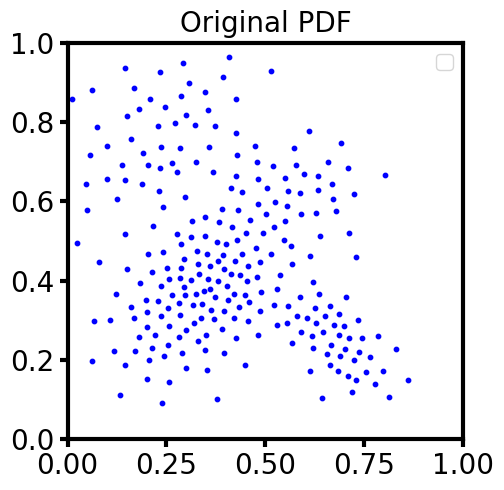

In [66]:
#mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.scatter(centroids[:, 0], centroids[:,1], s=10, color='blue')
#ax.scatter(mu_samples[::10, 0], mu_samples[::10, 1], s=10, color='green')
ax.legend(loc=1)
plt.show()
plt.close()

Step 10000, pos=[0.6211 0.66  ], metric=0.00037
Step 20000, pos=[0.3413 0.3234], metric=0.00569
Step 30000, pos=[0.6836 0.1707], metric=0.00255
Step 40000, pos=[0.1203 0.6125], metric=0.00142
Step 50000, pos=[0.2236 0.62  ], metric=0.00089
Step 60000, pos=[0.8461 0.1783], metric=0.00062
Step 70000, pos=[0.7133 0.2552], metric=0.00046
Step 80000, pos=[0.3428 0.4086], metric=0.00034
Step 90000, pos=[0.8284 0.2277], metric=0.00027
Step 100000, pos=[0.3217 0.4013], metric=0.00022


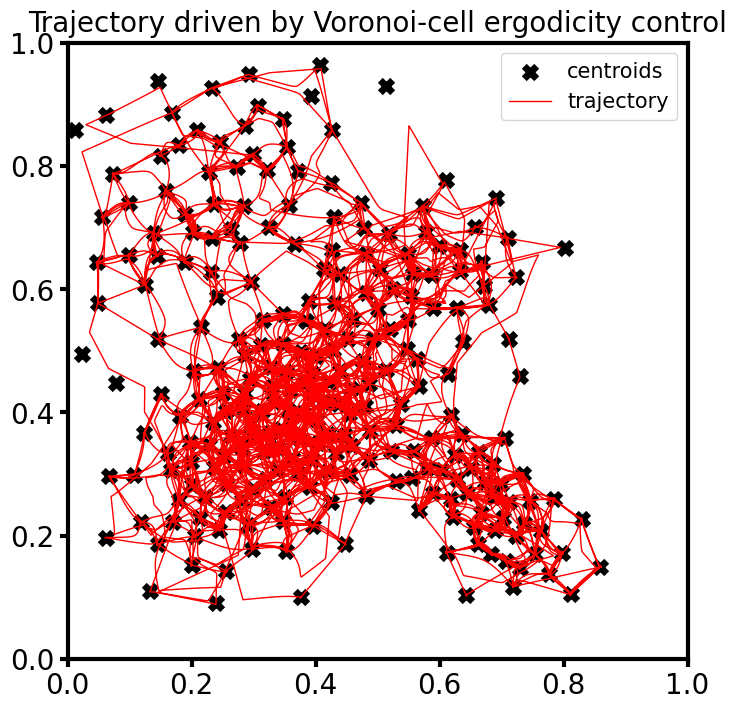

In [67]:
dt_emp = 0.01
tsteps = 100001
dt = dt_emp
ud = 0.2

def step(xt, ut):
    return xt + dt * ut
xt = np.array([0.5, 0.5])
x_traj = np.zeros((tsteps, 2))
traj_counts = np.zeros(N)
metric_log = []
for t in range(tsteps):
    # 1. Assign xt to nearest Voronoi centroid
    dists = np.linalg.norm(centroids - xt, axis=1)
    cell_idx = np.argmin(dists)
    #cell_idx = tree.query(xt)[1]
    traj_counts[cell_idx] += 1
    
    lambda_g = traj_counts / (t+1)
    e = (target_probs - lambda_g)
    e = np.maximum(0.0, e) 
    sigma = 0.05
    epsilon = 1e-12
    vectors = centroids - xt
    dist2 = np.sum(vectors**2, axis=1)
    weights = np.exp(-dist2 / sigma**2)
    direction = np.sum(e[:, None] * weights[:, None] * (vectors / dist2[:, None]), axis=0)
    ut = ud * direction / (np.linalg.norm(direction) + 1e-8)

    # 4. Step dynamics
    xt = step(xt, ut)
    x_traj[t] = xt.copy()

    # 5. Metric
    metric = np.sum((target_probs - lambda_g)**2)
    metric_log.append(metric)

    if t % 10000 == 0 and t != 0:
        print(f"Step {t}, pos={xt}, metric={metric:.5f}")

# --- Visualization ---
plt.figure(figsize=(8,8))
#plt.scatter(mu_samples[:,0], mu_samples[:,1], c=labels, cmap="tab20", s=5, alpha=0.3)
plt.scatter(centroids[:,0], centroids[:,1], c="black", marker="x", s=80, label="centroids")
plt.plot(x_traj[:,0], x_traj[:,1], c="red", linewidth=1, label="trajectory")
plt.legend()
plt.title("Trajectory driven by Voronoi-cell ergodicity control")
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()


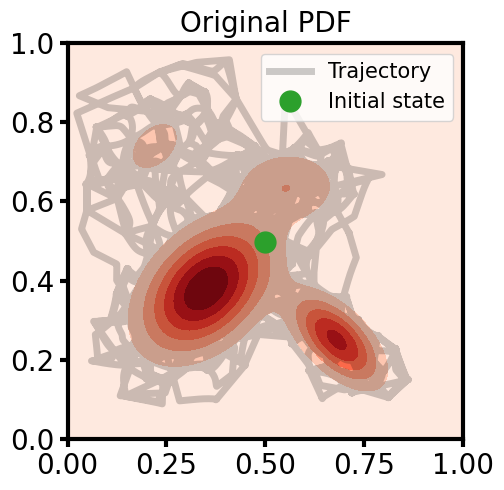

In [68]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(GX, GY, vals.reshape(ng, ng), cmap='Reds', alpha=0.6)
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', alpha=1.)
ax.plot(x_traj[:,0], x_traj[:,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()


In [70]:
im.kld(x_traj[:t,:],mu_samples[:t,:], approach='metric')


2.8653075228211344